In [ ]:
!pip install transformers
!pip install pytorch-lightning


from google.colab import drive
import re


from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import math

import gc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 57.3 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
test_path = '/content/drive/MyDrive/test.csv'
test_df = pd.read_csv(test_path)
test_df.shape

Mounted at /content/drive


(1500, 2)

In [ ]:
class ArticleDataSet(Dataset):
  def __init__(self, article_df, label_name, tokenizer, max_token_len: int = 512):
    '''
    takes feature dataframe (article text + title) and the label dataframe (numeric political bias)
    training, validation, test splits must be done BEFORE this step
    '''
    self.article_df = article_df
    self.tokenizer = tokenizer
    self.label_name = label_name
    self.max_token_len = max_token_len



  def __len__(self):
    return len(self.article_df)

  def __getitem__(self, index):
    item = self.article_df.iloc[index]
    label = item['bias']

    text_content = str(item.content_original)


    ## vectorize / encode

    tokens = self.tokenizer.encode_plus(text_content,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        max_length=self.max_token_len,
                                        padding='max_length',
                                        return_attention_mask=True)

    return {'input_ids': tokens.input_ids.flatten(),
            'attention_mask': tokens.attention_mask.flatten(),
            'label': label}


In [ ]:
class Article_Data_Module(pl.LightningDataModule):

  def __init__(self, train_ds, val_ds, test_ds, labels, batch_size: int = 16, max_token_len=512, model_name = 'roberta-base'):
    '''
    train_ds, val_ds, labels should all be data frames
    '''
    super().__init__()

    self.train_ds = train_ds
    self.val_ds = val_ds
    self.test_ds = test_ds
    self.labels = labels
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)



  def setup(self, stage=None):
    if stage in (None, "fit"):
      self.train_dataset = ArticleDataSet(self.train_ds, self.labels, self.tokenizer)
      self.val_dataset = ArticleDataSet(self.val_ds, self.labels, self.tokenizer)
    if stage in (None, "predict", "test"):
      self.test_dataset = ArticleDataSet(self.test_ds, self.labels, self.tokenizer)
      print(self.test_dataset.__get__item(0))




  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)


  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)


  def predict_dataloader(self):
    return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

In [ ]:
class Article_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)

    ## add in hidden layer and final layer

    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    self.hidden.bias.data.fill_(0)

    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.classifier.bias.data.fill_(0)

    self.loss_func = nn.CrossEntropyLoss()
    self.dropout = nn.Dropout()


  def forward(self, input_ids, attention_mask, label=None):
    '''
    label is None during prediction
    '''

    # roberta model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)

    # neural network classification layers

    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)



    loss = 0
    if label is not None:
      loss = self.loss_func(logits, label)
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)  # unpack - will call forward pass

    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": logits, "labels": batch['label']}


  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)

    self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss": loss, "predictions": logits, "labels": batch['label']}


  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

  def on_save_checkpoint(self, checkpoint):
    print("Saving checkpoint!\n")

    super().on_save_checkpoint(checkpoint)

In [ ]:
config = {
  'model_name' : 'distilroberta-base',
  'n_labels': 3,
  'batch_size': 16,
  'lr': 1.5e-6,
  'warmup': 0.2,
  'train_size': 10,
  'w_decay': 0.001,
  'n_epochs': 15
}



gc.collect()

torch.cuda.empty_cache()

if torch.cuda.is_available():
    device = torch.device("cuda")

model = Article_Classifier(config).to(device)



model_path = '/content/drive/MyDrive/model_final.ckpt'
model.load_state_dict(torch.load(model_path, map_location=device))

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
## INFERENCE

from torch.utils.data import TensorDataset

tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
inputs = tokenizer(test_df['content_original'].tolist(), padding=True, truncation=True, return_tensors="pt")

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
dataset = TensorDataset(input_ids, attention_mask)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)  # Define your batch size
predictions = []

with torch.no_grad():
    for batch in data_loader:
        batch_input_ids, batch_attention_mask = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        _, logits = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        batch_predictions = logits.argmax(dim=1).to('cpu')
        predictions.extend(batch_predictions.tolist())

# Update DataFrame and save
test_df['predicted_label'] = predictions
test_df.to_csv("gutcheck.csv", index=False)

In [ ]:
test_df.to_csv("/content/drive/MyDrive/gutcheck.csv")

In [ ]:
from sklearn.metrics import precision_score, recall_score


true_labels = test_df['bias']
predicted_labels = test_df['predicted_label']

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.8798290542050703
Recall: 0.8789179449084484


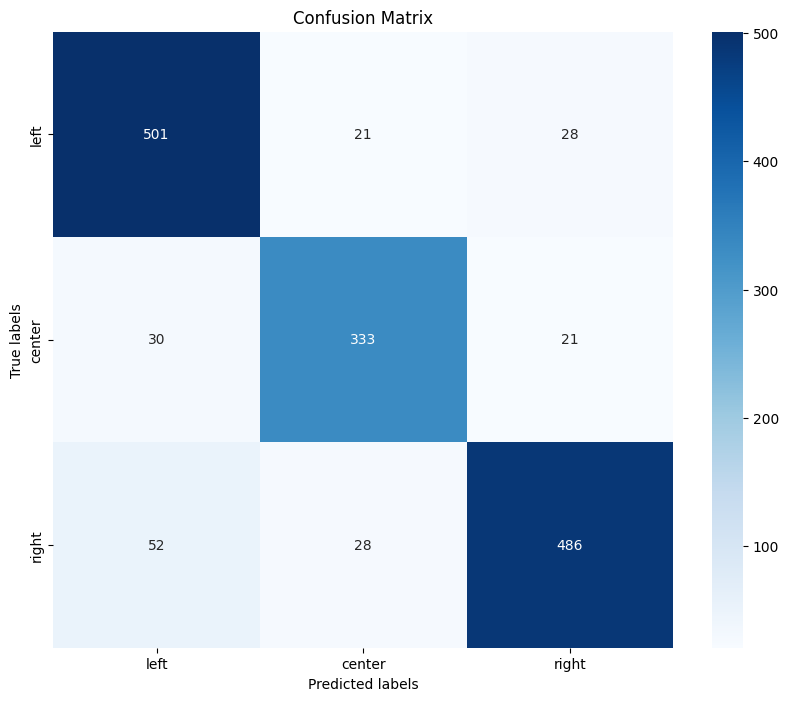

Accuracy: 0.88
              precision    recall  f1-score   support

        left       0.86      0.91      0.88       550
      center       0.87      0.87      0.87       384
       right       0.91      0.86      0.88       566

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



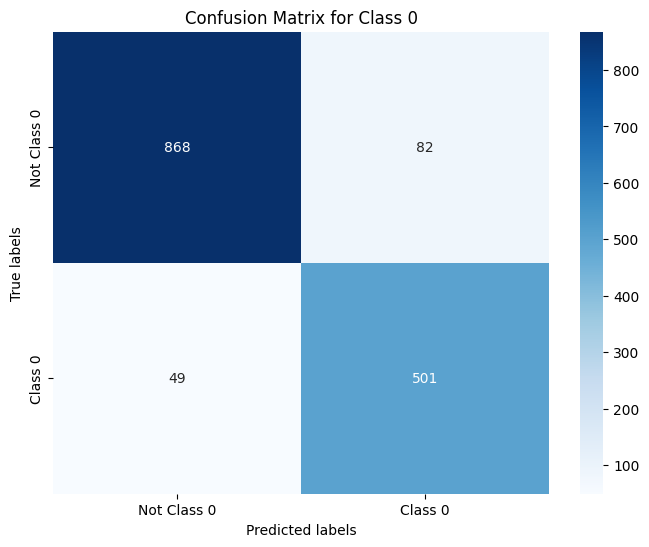

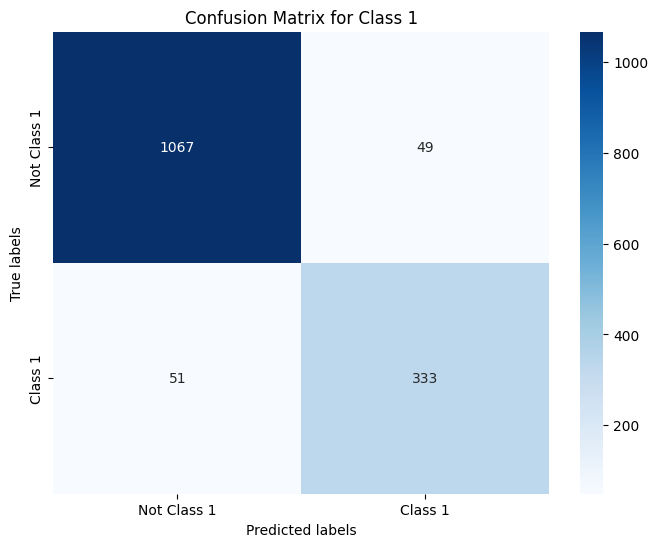

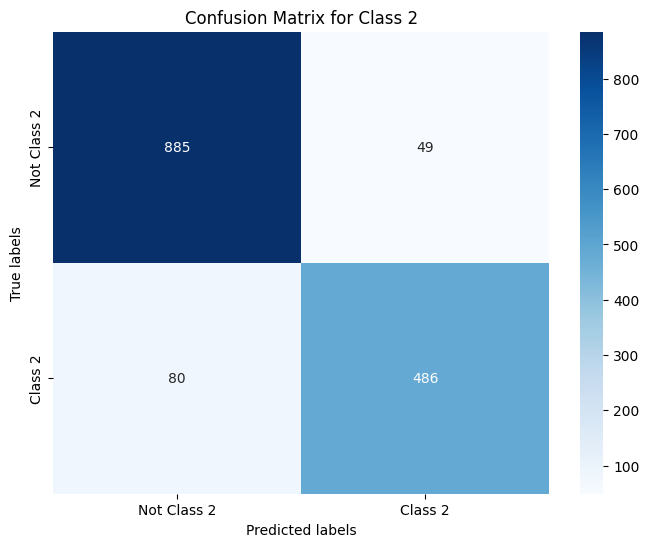

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

df = pd.read_csv("gutcheck.csv")

# Assuming 'bias' is the column with the true labels and 'predicted_label' with your model's predictions
true_labels = test_df['bias']
predicted_labels = test_df['predicted_label']

# Calculate the overall confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate the overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=['left', 'center', 'right'])

# Plot the overall confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['left', 'center', 'right'], yticklabels=['left', 'center', 'right'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy and classification report
print(f'Accuracy: {accuracy}')
print(report)

# Calculate and plot confusion matrix for each class
num_classes = len(np.unique(true_labels))
true_labels_one_hot = np.eye(num_classes)[true_labels]

predictions_one_hot = np.eye(num_classes)[predicted_labels]

for i in range(num_classes):
    class_i_true = true_labels_one_hot[:, i]
    class_i_pred = predictions_one_hot[:, i]
    conf_mat = confusion_matrix(class_i_true, class_i_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Class {}'.format(i), 'Class {}'.format(i)],
                yticklabels=['Not Class {}'.format(i), 'Class {}'.format(i)])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Class {}'.format(i))
    plt.show()
